In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import datetime
import numpy as np
from utils_3D import Q, rmsre  # Changed from utils_2D to utils_3D

In [13]:
# set precision (default is 'float32')
K.set_floatx('float64')

In [14]:
def load_data(fname):
    data = np.load(fname, allow_pickle=True)
    feq   = data['f_eq']
    fpre  = data['f_pre']
    fpost = data['f_post']
    return feq, fpre, fpost

###########################################################
# O_h Symmetry Group for D3Q19 (48 transformations)
# 
# The octahedral symmetry group O_h consists of:
#   - 24 proper rotations (orientation-preserving)
#   - 24 improper rotations (rotation × inversion)
#
# We generate these programmatically from basic rotation and
# reflection matrices applied to the D3Q19 stencil.
###########################################################

from utils_3D import c as D3Q19_STENCIL

def _find_permutation(transform_matrix, stencil):
    """
    Given a 3x3 transformation matrix (rotation or reflection),
    compute the permutation of stencil indices.
    
    Args:
        transform_matrix: 3x3 numpy array (rotation/reflection matrix)
        stencil: Nx3 array of velocity vectors
    
    Returns:
        List of indices where perm[i] is the new index of what was at index i
    """
    transformed = (transform_matrix @ stencil.T).T
    perm = []
    for vec in transformed:
        # Find which original index matches this transformed vector
        for j, orig_vec in enumerate(stencil):
            if np.allclose(vec, orig_vec):
                perm.append(j)
                break
    return perm

def _generate_rotation_matrices():
    """
    Generate the 24 rotation matrices of the cube using BFS from generators.
    
    Generators:
        Rx: 90° rotation around x-axis
        Ry: 90° rotation around y-axis  
        Rz: 90° rotation around z-axis
    """
    # 90° rotation matrices
    Rx = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]], dtype=np.float64)
    Ry = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]], dtype=np.float64)
    Rz = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]], dtype=np.float64)
    
    I = np.eye(3, dtype=np.float64)
    rotations = [I]
    visited = {tuple(I.flatten())}
    queue = [I]
    
    while queue:
        current = queue.pop(0)
        for gen in [Rx, Ry, Rz]:
            new_rot = current @ gen
            key = tuple(np.round(new_rot, 10).flatten())
            if key not in visited:
                visited.add(key)
                rotations.append(new_rot)
                queue.append(new_rot)
    
    return rotations

def _generate_Oh_transforms():
    """
    Generate all 48 O_h symmetry transformations.
    
    O_h = O × {I, -I} where O is the rotation group (24 elements)
    and -I is the inversion matrix.
    """
    rotations = _generate_rotation_matrices()
    inversion = -np.eye(3, dtype=np.float64)
    
    transforms = []
    for R in rotations:
        transforms.append(R)           # Proper rotation
    for R in rotations:
        transforms.append(inversion @ R)  # Improper rotation (rotoreflection)
    
    return transforms

# Generate all permutations at module load time
_OH_TRANSFORMS = _generate_Oh_transforms()
_OH_PERMS = [_find_permutation(T, D3Q19_STENCIL) for T in _OH_TRANSFORMS]
_OH_INV_PERMS = [[perm.index(i) for i in range(19)] for perm in _OH_PERMS]

# Verify we have exactly 48 unique permutations
assert len(set(tuple(p) for p in _OH_PERMS)) == 48, "Should have 48 unique permutations"


def LBrotate3D(f, transform_idx):
    """
    Apply the transform_idx-th O_h transformation to distribution f.
    
    Args:
        f: Tensor of shape (batch, 19)
        transform_idx: Integer index into the 48 O_h transformations
    
    Returns:
        Transformed tensor of shape (batch, 19)
    """
    perm = _OH_PERMS[transform_idx]
    return tf.gather(f, perm, axis=-1)


def LBrotate3D_inverse(f, transform_idx):
    """
    Apply the inverse of the transform_idx-th O_h transformation.
    
    Args:
        f: Tensor of shape (batch, 19)
        transform_idx: Integer index into the 48 O_h transformations
    
    Returns:
        Inverse-transformed tensor of shape (batch, 19)
    """
    inv_perm = _OH_INV_PERMS[transform_idx]
    return tf.gather(f, inv_perm, axis=-1)


class OhSymmetry(tf.keras.layers.Layer):
    """
    Apply all 48 O_h symmetry operations to D3Q19 distributions.
    
    The octahedral group O_h is the full symmetry group of the cube,
    consisting of 24 rotations and 24 rotoreflections.
    
    Permutation indices are computed programmatically from:
    1. Basic 90° rotation matrices around x, y, z axes
    2. BFS exploration to generate all 24 rotations
    3. Multiplication by inversion matrix for 24 rotoreflections
    """
    def __init__(self, **kwargs):
        super(OhSymmetry, self).__init__(**kwargs)
        self.perms = [tf.constant(p, dtype=tf.int32) for p in _OH_PERMS]

    def call(self, x):
        return [tf.gather(x, perm, axis=-1) for perm in self.perms]


class OhAntiSymmetry(tf.keras.layers.Layer):
    """
    Apply inverse O_h symmetry operations to restore original orientation.
    """
    def __init__(self, **kwargs):
        super(OhAntiSymmetry, self).__init__(**kwargs)
        self.inv_perms = [tf.constant(p, dtype=tf.int32) for p in _OH_INV_PERMS]

    def call(self, x):
        return [tf.gather(x[i], self.inv_perms[i], axis=-1) for i in range(48)]


class AlgReconstruction3D(tf.keras.layers.Layer):
    """
    Algebraic reconstruction for D3Q19 to enforce conservation laws.
    
    Conservation constraints (4 equations):
      - Mass: sum(df) = 0
      - Momentum-x: sum(df * cx) = 0
      - Momentum-y: sum(df * cy) = 0
      - Momentum-z: sum(df * cz) = 0
    
    We solve these 4 linear equations to express 4 components in terms
    of the remaining 15 free components that the NN predicts.
    
    Reconstructed indices: 0, 1, 3, 5 (rest, +x, +y, +z)
    Free indices: 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
    
    Derivation:
        From momentum-x: df1 + df7 + df8 - df9 - df10 + df15 + df16 - df17 - df18 = -df2
        Solving: df1 = df2 - df7 - df8 + df9 + df10 - df15 - df16 + df17 + df18
        
        Similarly for df3, df5, and df0 (mass constraint).
    """
    def __init__(self, **kwargs):
        super(AlgReconstruction3D, self).__init__(**kwargs)

    def call(self, fpre, fpred):
        df = fpred - fpre
        
        # Reconstruct from conservation constraints
        # df1: momentum-x constraint
        df1_new = (df[:,2] - df[:,7] - df[:,8] + df[:,9] + df[:,10] 
                   - df[:,15] - df[:,16] + df[:,17] + df[:,18])
        
        # df3: momentum-y constraint  
        df3_new = (df[:,4] - df[:,7] + df[:,8] - df[:,9] + df[:,10] 
                   - df[:,11] - df[:,12] + df[:,13] + df[:,14])
        
        # df5: momentum-z constraint
        df5_new = (df[:,6] - df[:,11] + df[:,12] - df[:,13] + df[:,14] 
                   - df[:,15] + df[:,16] - df[:,17] + df[:,18])
        
        # df0: mass constraint (sum of all must be zero)
        df0_new = (-2.0*df[:,2] - 2.0*df[:,4] - 2.0*df[:,6] 
                   + df[:,7] - df[:,8] - df[:,9] - 3.0*df[:,10]
                   + df[:,11] - df[:,12] - df[:,13] - 3.0*df[:,14]
                   + df[:,15] - df[:,16] - df[:,17] - 3.0*df[:,18])
        
        # Assemble reconstructed df tensor
        df_reconstructed = tf.concat([
            df0_new[:, None],   # 0: rest (reconstructed)
            df1_new[:, None],   # 1: +x (reconstructed)
            df[:, 2, None],     # 2: -x (free)
            df3_new[:, None],   # 3: +y (reconstructed)
            df[:, 4, None],     # 4: -y (free)
            df5_new[:, None],   # 5: +z (reconstructed)
            df[:, 6, None],     # 6: -z (free)
            df[:, 7, None],     # 7: +x+y (free)
            df[:, 8, None],     # 8: +x-y (free)
            df[:, 9, None],     # 9: -x+y (free)
            df[:, 10, None],    # 10: -x-y (free)
            df[:, 11, None],    # 11: +y+z (free)
            df[:, 12, None],    # 12: +y-z (free)
            df[:, 13, None],    # 13: -y+z (free)
            df[:, 14, None],    # 14: -y-z (free)
            df[:, 15, None],    # 15: +x+z (free)
            df[:, 16, None],    # 16: +x-z (free)
            df[:, 17, None],    # 17: -x+z (free)
            df[:, 18, None],    # 18: -x-z (free)
        ], axis=-1)
        
        return fpre + df_reconstructed


# Utility function to inspect the transformation group
def print_Oh_group_info():
    """Print information about the O_h symmetry group implementation."""
    print("O_h Symmetry Group for D3Q19")
    print("=" * 50)
    print(f"Total transformations: {len(_OH_PERMS)}")
    print(f"Unique permutations: {len(set(tuple(p) for p in _OH_PERMS))}")
    print(f"\nFirst 5 transformations:")
    for i in range(5):
        T = _OH_TRANSFORMS[i]
        det = np.linalg.det(T)
        rot_type = "rotation" if det > 0 else "rotoreflection"
        print(f"  {i}: {rot_type}, det={det:+.0f}")
    print(f"\nD3Q19 stencil structure:")
    print(f"  Rest particle: index 0")
    print(f"  Face directions: indices 1-6")
    print(f"  Edge directions: indices 7-18")

In [15]:
def sequential_model(Q=19, n_hidden_layers=2, n_per_layer=50, activation="relu", 
                     ll_activation="linear", bias=False):
    """Base sequential model for D3Q19 (19 input/output components)."""
    model = Sequential()
    
    model.add(Dense(n_per_layer, input_shape=(Q,), activation=activation, 
                    use_bias=bias, kernel_initializer="he_uniform"))
    
    for jj in range(n_hidden_layers):
        model.add(Dense(n_per_layer, activation=activation, 
                        use_bias=bias, kernel_initializer="he_uniform"))
    
    model.add(Dense(Q, activation=ll_activation, 
                    use_bias=bias, kernel_initializer="he_uniform"))

    return model 


def create_model_3D(loss="mape", optimizer="adam", Q=19, 
                    n_hidden_layers=2, n_per_layer=50, activation="relu", 
                    ll_activation="linear", bias=False):
    """Create physics-informed neural network for D3Q19 collision operator.
    
    Architecture:
    1. Input (19 components)
    2. OhSymmetry: Apply all 48 O_h symmetry operations
    3. Sequential NN: Process each symmetry variant
    4. AlgReconstruction3D: Enforce conservation laws
    5. OhAntiSymmetry: Reverse symmetry operations
    6. Average: Combine all 48 predictions
    """
    the_input = keras.Input(shape=(Q,))

    seq_model = sequential_model(Q, n_hidden_layers, n_per_layer, 
                                 activation, ll_activation, bias)
    
    # Apply 48 O_h symmetry transformations
    input_lst = OhSymmetry()(the_input)
    
    # Process each transformed input through the same network
    output_lst = [seq_model(x) for x in input_lst]

    # Apply algebraic reconstruction to enforce conservation
    output_lst = [AlgReconstruction3D()(input_lst[k], x) for k, x in enumerate(output_lst)]

    # Apply inverse symmetry transformations
    output_lst = OhAntiSymmetry()(output_lst)
    
    # Average over all 48 symmetry operations
    the_output = layers.Average()(output_lst)

    model = keras.Model(inputs=the_input, outputs=the_output)
    model.compile(loss=loss, optimizer=optimizer)    
    
    return model

In [16]:
###########################################################
# D3Q19 Physics-Informed Neural Network
#
# Key components:
# - Q = 19 velocity components
# - O_h symmetry group with 48 transformations (24 rotations x 2 for inversion)
# - 4 conservation constraints (mass + 3 momentum components)
# - 15 free parameters learned by NN, 4 reconstructed algebraically
#
# Architecture follows Prins thesis (2022) methodology extended to 3D:
# 1. Apply all 48 O_h symmetries to input
# 2. Process through shared sequential NN
# 3. Enforce conservation via algebraic reconstruction
# 4. Reverse symmetry operations
# 5. Average predictions for final output
###########################################################

In [17]:
# Read 3D training dataset
feq, fpre, fpost = load_data('example_dataset_3D.npz')

print(f"Dataset shape: {fpre.shape}")
print(f"Number of samples: {fpre.shape[0]}")
print(f"Number of velocity components (Q): {fpre.shape[1]}")

# Normalize data on density (scale invariance)
feq   = feq   / np.sum(feq, axis=1)[:, np.newaxis]
fpre  = fpre  / np.sum(fpre, axis=1)[:, np.newaxis]
fpost = fpost / np.sum(fpost, axis=1)[:, np.newaxis]

# Split train and test set (70/30)
fpre_train, fpre_test, fpost_train, fpost_test = train_test_split(
    fpre, fpost, test_size=0.3, shuffle=True, random_state=42
)

print(f"Training samples: {fpre_train.shape[0]}")
print(f"Test samples: {fpre_test.shape[0]}")

Dataset shape: (100000, 19)
Number of samples: 100000
Number of velocity components (Q): 19
Training samples: 70000
Test samples: 30000


In [18]:
# Training hyperparameters
batch_size = 32
n_epochs = 200
patience = 50
verbose = 1

# Create 3D model with O_h symmetry (48 augmentations)
model = create_model_3D(loss=rmsre, ll_activation="softmax")

print("Model summary:")
model.summary()

# EarlyStopping callback
es_callback = EarlyStopping(
    monitor="val_loss", 
    patience=patience, 
    restore_best_weights=True
)

# Save best weights during training
ck_callback = ModelCheckpoint(
    filepath="weights_3D.keras",  # Changed from weights_2D.keras
    monitor="val_loss", 
    save_best_only=True
)

keras_callbacks = [es_callback, ck_callback]

# Train the model
print("\nStarting training...")
hist = model.fit(
    fpre_train, fpost_train, 
    epochs=n_epochs, 
    verbose=verbose, 
    callbacks=keras_callbacks, 
    validation_data=(fpre_test, fpost_test), 
    batch_size=batch_size
)

Model summary:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ oh_symmetry_1       │ [(None, 19),      │          0 │ input_layer_2[0]… │
│ (OhSymmetry)        │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                   │
│                     │ (None, 19),       │            │                 

 Total params: 6,900 (53.91 KB)

 Trainable params: 6,900 (53.91 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
Epoch 1/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 55s 11ms/step - loss: 0.0232 - val_loss: 0.0100
Epoch 2/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 3/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0015 - val_loss: 8.7704e-04
Epoch 7/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 11/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0015 

In [19]:
# Load best weights and save complete model
model.load_weights("weights_3D.keras")
model.save("example_network_3D.keras")
print("Model saved to example_network_3D.keras")

Model saved to example_network_3D.keras


In [20]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss = model.evaluate(fpre_test, fpost_test)
print(f"\nFinal test loss (RMSRE): {test_loss:.6e}")

Evaluating model on test set...
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - loss: 2.2968e-04

Final test loss (RMSRE): 2.296830e-04


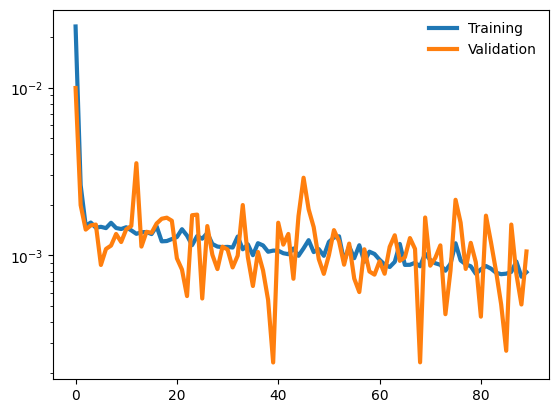

In [21]:
import matplotlib.pyplot as plt

plt.semilogy( hist.history['loss']    , lw=3, label='Training'   )
plt.semilogy( hist.history['val_loss'], lw=3, label='Validation' )

plt.legend(loc='best', frameon=False)

plt.show()